In [1]:
import git
from git import Repo

from unidiff import PatchSet

import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib
import sys
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

import editdistance

In [9]:
mutants_and_tests = pd.read_pickle('20200707-170152_flask_full_with_context.pkl')
len(mutants_and_tests)
mutants_and_tests

,mutant_id,contains_branch_mutant,contains_equality_comparison_mutant,contains_loop_mutant,contains_math_operands_mutant,current_line,line_number_changed,modified_file_path,modified_method,previous_line,...,setup_outcome,setup_duration,call_outcome,call_duration,teardown_outcome,teardown_duration,contains_branch_execution,contains_loop_execution,contains_math_operands_execution,contains_equality_comparison_execution
0,1977.0,1.0,0.0,0.0,1.0,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,True,0.031885,True,0.000806,True,0.000296,False,False,True,False
1,1977.0,1.0,0.0,0.0,1.0,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,True,0.001572,True,0.000364,True,0.000240,False,True,False,False
2,1977.0,1.0,0.0,0.0,1.0,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,True,0.000355,True,0.000237,True,0.000219,False,True,False,False
3,1977.0,1.0,0.0,0.0,1.0,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,True,0.001527,True,0.000934,True,0.000243,False,False,False,True
4,1977.0,1.0,0.0,0.0,1.0,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,True,0.001606,True,0.000288,True,0.000238,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958036,2092.0,1.0,1.0,0.0,1.0,"mimetype=current_app.config[""XXJSONIFY_...",336.0,src/flask/json/__init__.py,jsonify,,...,True,0.001344,True,0.001591,True,0.000247,False,False,False,False
958037,2092.0,1.0,1.0,0.0,1.0,"mimetype=current_app.config[""XXJSONIFY_...",336.0,src/flask/json/__init__.py,jsonify,,...,True,0.001295,True,0.002982,True,0.000226,False,False,False,False
958038,2092.0,1.0,1.0,0.0,1.0,"mimetype=current_app.config[""XXJSONIFY_...",336.0,src/flask/json/__init__.py,jsonify,,...,True,0.001311,True,0.001594,True,0.000247,False,False,False,False
958039,2092.0,1.0,1.0,0.0,1.0,"mimetype=current_app.config[""XXJSONIFY_...",336.0,src/flask/json/__init__.py,jsonify,,...,True,0.001978,True,0.001632,True,0.000247,False,False,False,False


In [10]:
display(mutants_and_tests.groupby(['modified_method', 'name']).count())

mutant_id  \
modified_method    name                                                            
Blueprint          TestGenericHandlers::test_handle_class_or_code[...          9   
                   TestGenericHandlers::test_handle_class_or_code[...          9   
                   TestGenericHandlers::test_handle_generic                    9   
                   TestGenericHandlers::test_handle_generic_http               9   
                   TestGreenletContextCopying::test_greenlet_conte...          9   
...                                                                          ...   
wsgi_errors_stream test_werkzeug_passthrough_errors[True-True-True...          2   
                   test_werkzeug_passthrough_errors[True-True-True...          2   
                   test_werkzeug_routing                                       2   
                   test_with_appcontext                                        2   
                   test_wsgi_errors_stream                                     2   

                                                                       contains_branch_mutant  \
modified_method    name                                                                         
Blueprint          TestGenericHandlers::test_handle_class_or_code[...                       9   
                   TestGenericHandlers::test_handle_class_or_code[...                       9   
                   TestGenericHandlers::test_handle_generic                                 9   
                   TestGenericHandlers::test_handle_generic_http                            9   
                   TestGreenletContextCopying::test_greenlet_conte...                       9   
...                                                                                       ...   
wsgi_errors_stream test_werkzeug_passthrough_errors[True-True-True...                       2   
                   test_werkzeug_passthrough_errors[True-True-True...                       2   
                   test_werkzeug_routing                                                    2   
                   test_with_appcontext                                                     2   
                   test_wsgi_errors_stream                                                  2   

                                                                       contains_equality_comparison_mutant  \
modified_method    name                                                                                      
Blueprint          TestGenericHandlers::test_handle_class_or_code[...                                    9   
                   TestGenericHandlers::test_handle_class_or_code[...                                    9   
                   TestGenericHandlers::test_handle_generic                                              9   
                   TestGenericHandlers::test_handle_generic_http                                         9   
                   TestGreenletContextCopying::test_greenlet_conte...                                    9   
...                                                                                                    ...   
wsgi_errors_stream test_werkzeug_passthrough_errors[True-True-True...                                    2   
                   test_werkzeug_passthrough_errors[True-True-True...                                    2   
                   test_werkzeug_routing                                                                 2   
                   test_with_appcontext                                                                  2   
                   test_wsgi_errors_stream                                                               2   

                                                                       contains_loop_mutant  \
modified_method    name                                                                       
Blueprint          TestGenericHandlers::test_handle_class_or_code[...                     9   


In [11]:
# Add to each mutant_and_test the levenstein distance
mutants_and_tests['edit_distance_method_name_test_name'] = mutants_and_tests.apply(lambda row: editdistance.eval(str(row.modified_method), str(row.name)), axis=1) 

In [12]:
mutants_and_tests['edit_distance_method_name_test_name'].value_counts()

6     157258
8     136670
9      75350
13     69734
12     66924
11     58034
7      57101
18     53820
14     38379
19     36036
17     31824
23     25272
16     24336
33     19656
21     19189
5      17317
15     15913
20      9832
22      9360
24      7020
28      6084
31      5148
10      4680
41      3744
29      3276
27      2340
30      1872
42       936
26       468
4        468
Name: edit_distance_method_name_test_name, dtype: int64

In [6]:
def bool_to_int(x):
    if x == True:
        return 1
    return 0
mutants_and_tests['outcome_binary'] = mutants_and_tests['outcome'].apply(bool_to_int)

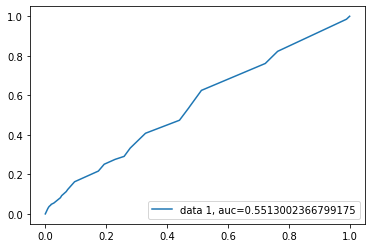

In [7]:
# A good predictor?
fpr, tpr, thresholds = metrics.roc_curve(mutants_and_tests['outcome_binary'], mutants_and_tests['edit_distance_method_name_test_name'])
auc = metrics.roc_auc_score(mutants_and_tests['outcome_binary'], mutants_and_tests['edit_distance_method_name_test_name'])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [14]:
mutants_and_tests.to_pickle('flask_full_with_edit_distances_and_context.pkl')